# MIE 1624 Assignment 1: Sentimental Analysis

“What can public opinion on Twitter tell us about the US airlines in 2015?”


In [1]:
#Import all library needed for this assignment:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import datetime
import pytz

## Step 1: Data Processing 


The data processing step ensures that:
1. All html characters are mapped to their corresponding ASCII symbols
2. All non letter characters are removed
3. All letters are mapped to lowercase letter
4. All stop words are removed (stop words are words that are considered to be the most common words in the english language)

**Upload all files into the pandas data frame work:**

In [2]:
generic_tweets = pd.read_csv('generic_tweets.txt', delimiter = ',')
airline_tweets = pd.read_csv('US_airline_tweets.csv')
corpus = pd.read_csv('corpus.txt', names = ['word','score'], delim_whitespace=True)
stop_words = pd.read_csv('stop_words.txt',names = ['word'])

**Parse the html symbols to its ASCII equivalent:**

In [3]:
def parse_html(text):
    '''
    Function use html parser to read the text and returns a string with the corresponding ASCII equivalent symbols

    '''
    doc=BeautifulSoup(text, 'html.parser')
    return doc.get_text()

# Clean the generic tweets and the airline tweets data:
generic_tweets['text'] = generic_tweets['text'].apply(parse_html)
airline_tweets ['text'] = airline_tweets['text'].apply(parse_html)

**Remove URLs from the tweets:**

In [4]:
def remove_URL(text):
    '''
    Function remove url with similar patterns and returns a string without the URL
    Patterns are:
        -start with https and end with a white space
        -start with http and end with a white space
        -start with www and end with a white space
        
    '''
    URLless1 = re.sub(r'https\S+', '', text)
    URLless2 = re.sub(r'http\S+', '', URLless1)
    URLless3 = re.sub(r'www\S+', '',URLless2)
    return URLless3

# Remove URLs from the generic tweets and the airline tweets data:
generic_tweets['text'] = generic_tweets['text'].apply(remove_URL)
airline_tweets ['text'] = airline_tweets['text'].apply(remove_URL)

**Remove all non alphabet characters and extra white spaces in the tweets:** <br/>
note: "at" symbols are kept to extract airlines names in the next step, and will be removed in a later step

In [5]:
def remove_nonletter_exspace(text):
    '''
    Function remove all non alphabet characters (except '@') and extra white spaces
    returns a string in all lowercase letters
        
    '''
    only_letter= re.sub(r'[^a-zA-Z@ ]+',' ',text)
    remove_exspace=re.sub(r' +', ' ',only_letter)
    remove_exspace=remove_exspace.strip()  #remove leading and trailing whitespaces
    return  remove_exspace.lower() # return all words in lower case letter

generic_tweets['text'] = generic_tweets['text'].apply(remove_nonletter_exspace)
airline_tweets ['text'] = airline_tweets['text'].apply(remove_nonletter_exspace)

**Remove all @User_name from general tweets:**

In [6]:
def remove_at(text):
    '''
    Remove all words that start with @ and end with a white space
    return a string
    '''
    text = re.sub(r'@\S+', '',text)
    return text

generic_tweets['text'] = generic_tweets['text'].apply(remove_at)

**Remove all the stops words using the nltk library list:**

In [7]:
from nltk.corpus import stopwords
stop_Words_list_nltk = set(stopwords.words('english'))

def remove_stop_word(text):
    '''
    The input text is split into an array of individual words.
    The word will be removed from the tweet if it's present in the stop_words lists.
    A new string without stop words is returned.
    
    '''
    words=text.split()
    new_text=''
    for i in words:
        if i not in stop_Words_list_nltk: #if the word is not in the stop_word list
            new_text=new_text+' '+ i #add the word to the final string
    return new_text

generic_tweets['text'] = generic_tweets['text'].apply(remove_stop_word)
airline_tweets['text'] = airline_tweets['text'].apply(remove_stop_word)
stop_words_list = None
stop_Words_list_nltk = None

**Perform lemmatisation:**

In [8]:
from nltk.stem import WordNetLemmatizer 
#nltk.download('punkt')
#nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatizing(text):
    """
    Caryy out lemmatizing on each word, aiming to remove inflectional endings 
    and to return the base or dictionary form of a word, which is known as the lemma . 
    
    """
    words=text.split()
    new_text=''
    
    for i in words:
         new_text=new_text+' '+ lemmatizer.lemmatize(i)
    return new_text.strip()

generic_tweets['text'] = generic_tweets['text'].apply(lemmatizing)

**Preview first 10 rows of data:**

In [9]:
generic_tweets.head(10)

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many time ball managed save rest go bound
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time see yes rain bit bit lol fine th...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,k nope
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que muera


## Step 2: Exploratory Analysis

To get a preview of the data before building a model, the following steps are taken:
1. Extract the airline name from a tweet
2. Perform data visualisation to get a better idea of the sample distribution. 
    * US airlines distribution
    * General tweet positive/negative samples distribution
    * US airlines tweet positive/negative samples distribution 


### 2.1 Extract the airline name from the tweets:

**Store the airline in another column before deleting it from the tweet:**

In [10]:
def store_airline(text):
    '''
    Function stracted the airline the tweet is refering too and map it to a common way of spelling the airline
    
    A dictionary is built with all possible airlines mentioned in the US_airline_tweets.csv file
    1. All instanced of the @username is found
    2. If the @username matches with a airline in the dictionary, then the airline name is returned
    
    note: the function will return the first match even if there are more airlines mentioned in the tweet
    '''
    airlines ={'@virginamerica':'Virgin America', '@united':'United  Airlines', '@southwestair':'South West Air', '@jetblue':'JetBlue', '@usairways':'USAirways', '@americanair':'AmericanAir', '@deltaassist':'Delta Air Lines'}
    airline=re.findall(r'@\S+',text)
    for i in airline:
        if i in airlines:
            return airlines[i]
        
airline_tweets ['airlines'] = airline_tweets['text'].apply(store_airline)

**Check for any missing airline data and fill the data in manually if possible:**

In [11]:
print(airline_tweets[airline_tweets ['airlines'].isnull()])
# the null tweet was from JetBlue themselves, and thus will be filled in as 'JetBlue'
airline_tweets.at[6184, 'airlines'] ='JetBlue' 

                id sentiment negative_reason     user  retweet_count  \
6184  5.686020e+17  positive             NaN  JetBlue              3   

                                                 text airlines  
6184   @ninadavuluri think treat onboard enjoy flight     None  


**Remove all @User_name from tweets and perform lemmatization:**

In [12]:
airline_tweets['text'] = airline_tweets['text'].apply(remove_at)
airline_tweets['text'] = airline_tweets['text'].apply(lemmatizing)

In [13]:
# Preview the data:
airline_tweets.head(10)

,id,sentiment,negative_reason,user,retweet_count,text,airlines
0,5.703010e+17,positive,NaN,jnardino,0,plus added commercial experience tacky,Virgin America
1,5.703010e+17,negative,Bad Flight,jnardino,0,really aggressive blast obnoxious entertainmen...,Virgin America
2,5.703010e+17,negative,Can't Tell,jnardino,0,really big bad thing,Virgin America
3,5.703010e+17,negative,Can't Tell,jnardino,0,seriously would pay flight seat playing really...,Virgin America
4,5.703010e+17,positive,NaN,cjmcginnis,0,yes nearly every time fly vx ear worm go away,Virgin America
5,5.703000e+17,positive,NaN,dhepburn,0,well,Virgin America
6,5.702950e+17,positive,NaN,YupitsTate,0,amazing arrived hour early good,Virgin America
7,5.702900e+17,positive,NaN,HyperCamiLax,0,pretty graphic much better minimal iconography,Virgin America
8,5.702900e+17,positive,NaN,HyperCamiLax,0,great deal already thinking nd trip even gone ...,Virgin America
9,5.702870e+17,positive,NaN,mollanderson,0,flying fabulous seductive sky u take stress aw...,Virgin America


**US airline tweet distribution:**

In [14]:
airline_tweets_dist = airline_tweets.groupby(by='airlines', as_index=False).agg({'text': pd.Series.count})
airline_tweets_dist  = airline_tweets_dist.sort_values(by='text', ascending=False)
print(airline_tweets_dist)
print('Total number of tweets: '+ str(airline_tweets_dist['text'].sum()))

           airlines  text
5  United  Airlines  3124
4         USAirways  2532
0       AmericanAir  2296
3    South West Air  1757
2           JetBlue  1497
6    Virgin America   333
1   Delta Air Lines     2
Total number of tweets: 11541


**Discussion:**

The number of tweets for Delta Air Lines is significantly lower than the other airlines. With just two tweets, it will be hard to gage the public's opinion on Delta Air Lines. More samples needs to be collected for a conclusive analysis.

The next lowest sample size is Virgin America. Even though 333 tweets is munch higher than 2 tweets, it is still smaller compared to the other samples. As such, the result obtained for Virgin America will be less confident than the other airlines. 

According to the U.S. Department of Transportation's Bureau of Transportation Statistics (BTS), U.S. airlines carried 849.3 million passengers systemwide. The total number of tweets in this case is munch smaller than the total population, and might be biased towards social media users.

## 2.2 Visualize the data:

**Visualize the US airline distribution:**

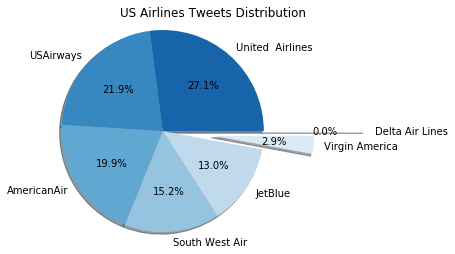

In [15]:
#data to plot:
labels = airline_tweets_dist['airlines'].values
sizes = airline_tweets_dist['text'].values

# Plot
cmap = plt.get_cmap('Blues_r')
colors = [cmap(i) for i in np.linspace(0.2, 1, 7)]
explode = (0, 0, 0, 0, 0,0.5, 1)

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, colors=colors, explode=explode)
plt.title('US Airlines Tweets Distribution', fontsize=12)
plt.axis('equal')
plt.show()

**Visualize the percent of negative vs positive tweet for each airline:**

In [16]:
# Perform pivot table count of negative and positive tweets for each airlines:
airline_tweets_dist = pd.pivot_table(airline_tweets, values='text', index=['airlines'], columns=['sentiment'], aggfunc='count')
airline_tweets_dist.loc['Delta Air Lines', 'positive'] = 0

# Calculate sentiment in percent of total tweets:
airline_tweets_dist['%_negative'] = airline_tweets_dist['negative']/(airline_tweets_dist['negative']+airline_tweets_dist['positive'])
airline_tweets_dist['%_positive'] = airline_tweets_dist['positive']/(airline_tweets_dist['negative']+airline_tweets_dist['positive'])
airline_tweets_dist['Total'] = (airline_tweets_dist['negative']+airline_tweets_dist['positive'])

# Sort the airlines by their total number of tweets and reset index fro graphing
airline_tweets_dist  = airline_tweets_dist.sort_values(by='Total', ascending=False)
airline_tweets_dist= airline_tweets_dist.reset_index()

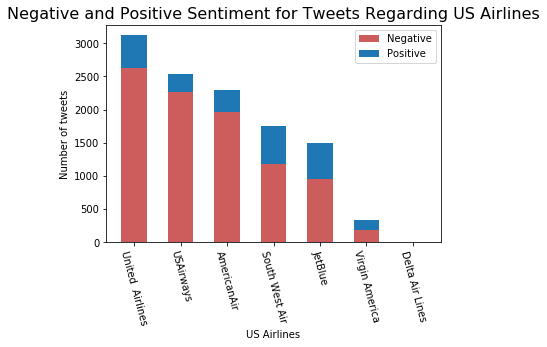

In [17]:
#data to plot:
labels = airline_tweets_dist['airlines'].values

neg = airline_tweets_dist.negative.values
pos = airline_tweets_dist.positive.values

ind = np.arange(len(labels))    
width = 0.55  

p1 = plt.bar(ind, neg, width,color='indianred')
p2 = plt.bar(ind, pos, width, bottom=neg)

plt.ylabel('Number of tweets')
plt.xlabel('US Airlines')
plt.title('Negative and Positive Sentiment for Tweets Regarding US Airlines', fontsize=16)
plt.xticks(ind, labels)
plt.xticks(rotation=-75)
plt.legend((p1[0], p2[0]), ('Negative', 'Positive'))

plt.show()

**Visualize the General Tweets Data**

Find how the total number of tweets, the percent positive, and percent negative tweets. 

In [18]:
generic_tweets ['emotion'] = generic_tweets['class'].apply(lambda x: 'negative' if (x==0) else 'positive')
generic_tweets_dist = generic_tweets.groupby(['emotion']).agg({'text': pd.Series.count})
generic_tweets_dist["Percent"] = generic_tweets_dist.loc[['negative'],['text']].values[0][0]/generic_tweets_dist['text'].sum()
generic_tweets_dist= generic_tweets_dist.reset_index()

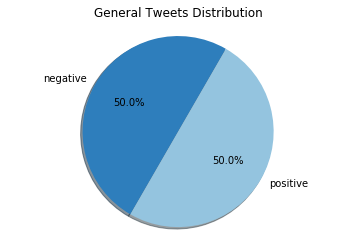

In [19]:
#data to plot:
labels = generic_tweets_dist['emotion'].values
sizes = generic_tweets_dist['text'].values

# Plot
cmap = plt.get_cmap('Blues_r')
colors = [cmap(i) for i in np.linspace(0.3, 0.6, 2)]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, colors=colors,startangle =60)
plt.title('General Tweets Distribution', fontsize=12)
plt.axis('equal')
plt.show()

Find the distribution for the length of tweets after data cleaning.

In [20]:
generic_tweets['number_words'] = generic_tweets['text'].apply(lambda x: len(x.split()))

Text(0.5,1,'Number of words in a tweet (not including stop words)')

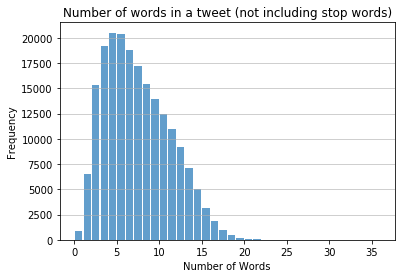

In [21]:
n, bins, patches = plt.hist(x=generic_tweets['number_words'], bins=36, color = cmap(0.3),alpha=0.75, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Number of words in a tweet (not including stop words)')

## Step 3: Model Preparation

In [22]:
# Import all library needed:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

**Count the freqeuncy of each word in every tweet:**

Use the tokenizer and frequency count library to count the freqeuncy of each word in a tweet:

In [79]:
# A giant array is generated where the row is the tweet and the coloums are all possible words in the generict_tweet data set
# The values are the frequency of each word present in the corresponding tweet
cv = CountVectorizer()
data = cv.fit_transform(generic_tweets['text'])

Normalise the frequency count:

In [80]:
# Even though stops words are removed, there might still be words that are present way more frequent than others.
# If the direct count data was fed to a classifier, those very frequent terms would shadow the frequencies of rarer yet more interesting terms.
# As such, the frequency data is normalised first by the euclidian norm and then fed into the model.
transformer = TfidfTransformer(smooth_idf=False)
data_norm = transformer.fit_transform(data)
data_norm.shape

(200000, 71285)

**Seperate the data into training and testing data set:**

In [69]:
# Define the feature input matrix, X and the output vecot, y:
X = data_norm
y = generic_tweets['emotion']
y_labels = generic_tweets['emotion'].unique()

In [70]:
# Split the datat into 70% training and 30% testing sets:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

## Step 4 : Model Implementation 

In [71]:
# Importing libraries from sklearn:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### 4.1 Model implementation for the general tweets sentimental analysis

#### 4.1.1 Train a logistic regression model using generic tweets:

In [72]:
# Perfrom lofistic regression on the training data:
log = LogisticRegression(solver = 'liblinear', max_iter=1000)
log.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [73]:
# Predict the outcome using the test data:
y_pred=log.predict(X_test)

In [74]:
# Define a function to plot decision matrix:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, rotation = 0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=rotation)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]) :
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


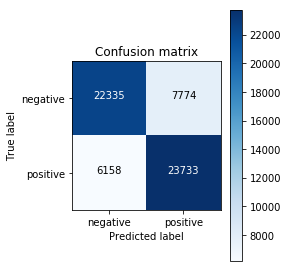

In [75]:
# Compute a confusion matrix:
cm = confusion_matrix(y_test,y_pred, labels = y_labels)

# Plot the confusion matrix:
np.set_printoptions(precision=1)
plt.figure(figsize=(4,4))
plot_confusion_matrix(cm, classes=y_labels, normalize=False, title='Confusion matrix')
plt.show()

In [76]:
# Print he accuracy score of the predicted output vs the real output of the test data:
print('Accuracy: %.2f%%' % (accuracy_score(y_pred,y_test)*100))

Accuracy: 76.78%


In [33]:
# Print all perfromance scores for the testing data set:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.78      0.74      0.76     30109
    positive       0.75      0.79      0.77     29891

   micro avg       0.77      0.77      0.77     60000
   macro avg       0.77      0.77      0.77     60000
weighted avg       0.77      0.77      0.77     60000



#### 4.1.2 Test the model trained using generic tweets on the US airline data

In [34]:
# Compute a new freqeuncy matrix for the US airline tweets using the same feature as the model trained using the generic tweets:
data = cv.transform(airline_tweets['text'])
data_norm = transformer.transform(data)
data_norm.shape

(11541, 71285)

In [35]:
# Set all data to test data:
X_test = data_norm
y_test = airline_tweets['sentiment']
y_labels = airline_tweets['sentiment'].unique()

In [36]:
# Predict the sentiment of the US airline tweet:
y_pred=log.predict(X_test)

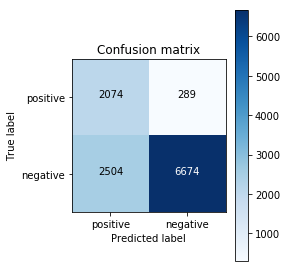

In [37]:
# Compute the confusion matrix:
cm = confusion_matrix(y_test,y_pred, labels = y_labels)

# Plot the confusion matrix:
np.set_printoptions(precision=1)
plt.figure(figsize=(4,4))
plot_confusion_matrix(cm, classes=y_labels, normalize=False, title='Confusion matrix')
plt.show()

In [38]:
# Print the accuracy score:
print('Accuracy: %.2f%%' % (accuracy_score(y_pred,y_test)*100))

Accuracy: 75.80%


In [39]:
# Print all performance scores:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.96      0.73      0.83      9178
    positive       0.45      0.88      0.60      2363

   micro avg       0.76      0.76      0.76     11541
   macro avg       0.71      0.80      0.71     11541
weighted avg       0.86      0.76      0.78     11541



### 4.2 Model implementation for the negative US airlines tweets classification

#### 4.2.1 Prepare and visualize the data

In [40]:
# Filter the tweets for only negative comments regarding US airlines:
airline_tweets_neg = airline_tweets[airline_tweets.sentiment=='negative']

In [41]:
# List all categories and the corresponding number of tweets:
# This is done to see if class imbalance will be an issue.
airline_tweets_neg_dist = airline_tweets_neg.groupby(by='negative_reason').agg({'text': pd.Series.count})
airline_tweets_neg_dist  = airline_tweets_neg_dist.sort_values(by='text', ascending=False)
airline_tweets_neg_dist

,text
negative_reason,
Customer Service Issue,2910
Late Flight,1665
Can't Tell,1190
Cancelled Flight,847
Lost Luggage,724
Bad Flight,580
Flight Booking Problems,529
Flight Attendant Complaints,481
longlines,178


The two last categories, "longlines" and "Damaged Luggage", have significantly less tweets than the other categories. As a restult, they might suffer from class imbalance, which means that there is not enough examples to properly train the model to identify those classes. The model will have a tendency of classifiying a tweet into the other categories with more examples. 

To counter the issue above, the last two classes will be combined with other similar ones. The "Damaged Luggage" category will be combined with the "Lost Luggage" since both of them refer to luggages, and the "longlines" will be combined with the "Customer Service Issue" category since both of them imply unsatisfactory interraction with airline personel. One can argue that waiting in line for too long is one example of unsatisfactory custumer service. 

The "Flight Booking Problem" category is very similar to the 'customer service issue' category, because booking a flight often involve interacting with an airline representative. Those two groups will be combined as well. 

In [42]:
# Combining the categories mentioned above:
def group_classes(neg):
    if neg == 'Damaged Luggage' or neg == 'Lost Luggage':
        return 'Lost or Damaged Luggage'
    elif neg == "longlines" or neg == 'Flight Booking Problems':
        return 'Customer Service Issue'
    else :
        return neg
    
airline_tweets_neg['grp_negative_reason'] = airline_tweets_neg['negative_reason'].apply(group_classes)

# Reprinting the distribution:
airline_tweets_neg_dist = airline_tweets_neg.groupby(by='grp_negative_reason').agg({'text': pd.Series.count})
airline_tweets_neg_dist  = airline_tweets_neg_dist.sort_values(by='text', ascending=False)
airline_tweets_neg_dist

C:\Users\Lilly\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,text
grp_negative_reason,
Customer Service Issue,3617
Late Flight,1665
Can't Tell,1190
Cancelled Flight,847
Lost or Damaged Luggage,798
Bad Flight,580
Flight Attendant Complaints,481


#### 4.2.2 Model input and output preparation

In [43]:
# Generate the bag of words array:
data = cv.fit_transform(airline_tweets_neg['text'])
data_norm = transformer.fit_transform(data)
data_norm.shape

(9178, 7790)

In [57]:
# Define the feature input matrix, X and the output vector, y:
X = data_norm
y = airline_tweets_neg['grp_negative_reason']
y_labels = airline_tweets_neg['grp_negative_reason'].unique()

array(['Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Lost or Damaged Luggage',
       'Flight Attendant Complaints', 'Cancelled Flight'], dtype=object)

In [52]:
# Split the datat into 70% training and 30% testing sets:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=11)

In [53]:
# Perform logistic regression:
log = LogisticRegression( solver = 'saga', multi_class = 'auto', max_iter=1000)
log.fit(X_train,y_train)

# Test the model on the testing data:
y_pred=log.predict(X_test)

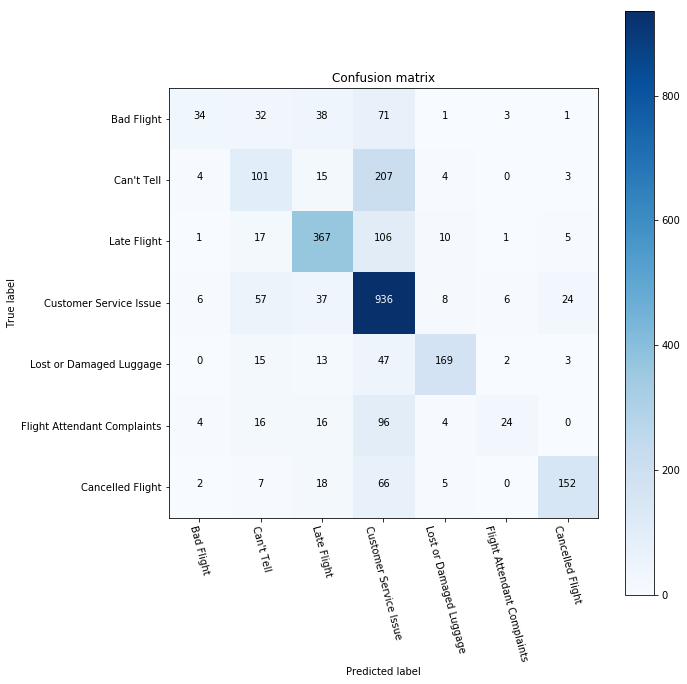

In [54]:
# Compute the confusion matrix:
cm = confusion_matrix(y_test,y_pred,labels = y_labels)

# Plot the confusion matrix:
np.set_printoptions(precision=1)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=y_labels, normalize=False,title='Confusion matrix',rotation = -75)
plt.show()

In [55]:
# Print the accuracy score:
print('Accuracy: %.2f%%' % (accuracy_score(y_test,y_pred)*100))

Accuracy: 64.74%


In [56]:
# Print all performance scores:
print(classification_report(y_test,y_pred))

                             precision    recall  f1-score   support

                 Bad Flight       0.67      0.19      0.29       180
                 Can't Tell       0.41      0.30      0.35       334
           Cancelled Flight       0.81      0.61      0.69       250
     Customer Service Issue       0.61      0.87      0.72      1074
Flight Attendant Complaints       0.67      0.15      0.24       160
                Late Flight       0.73      0.72      0.73       507
    Lost or Damaged Luggage       0.84      0.68      0.75       249

                  micro avg       0.65      0.65      0.65      2754
                  macro avg       0.68      0.50      0.54      2754
               weighted avg       0.65      0.65      0.62      2754



## Step 5: Results discussion